# STAT 542 / CS 598: Homework 3

Fall 2019, by Edgar Pino

Due: Monday, Oct 7 by 11:59 PM Pacific Time

# Question 1 [50 Points] A Simulation Study


In [435]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
import matplotlib.pyplot as plt
from basis_expansions import NaturalCubicSpline
from scipy.interpolate import UnivariateSpline

import rpy2
import rpy2.robjects as robjects
from rpy2.robjects.packages import importr
from rpy2.robjects import numpy2ri
numpy2ri.activate()

## Training data n=30: Generate x from [−1,1] uniformly, and then generate y=sin(πx)+ϵ, where ϵ’s are iid standard normal

In [460]:
def gen_train_data(n=30):
    x_train = np.random.uniform(-1,1,n)
    epsilon = np.random.randn(n)
    y_train = np.sin((x * np.pi)) + epsilon
    return x_train, y_train

In [463]:
x, y = gen_train_data()

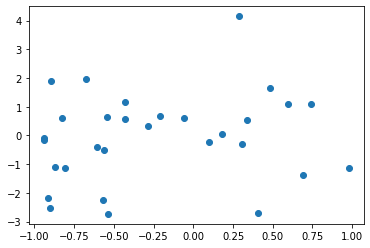

In [465]:
plt.plot(x, y, 'o')
plt.show()

## Write your own code (you cannot use bs() or similar functions) to implement a continuous piecewise linear spline fitting. Choose knots at 

In [466]:
class ContinuousPiecewiseLinearSpline(BaseEstimator, TransformerMixin):
    def __init__(self, knots=None):
        self.knots = np.asarray(knots)
        
    def fit(self, *args, **kwargs):
        return self
    
    def transform(self, x):
        n_knots = len(self.knots)
        knots = np.asarray(self.knots)
        ls = np.zeros((x.shape[0], n_knots + 1))
        ls[:, 0] = x.squeeze()

        for i, knot in enumerate(knots, start=1):
            ls[:, i] = np.maximum(0, x - knot).squeeze()
        
        return ls

In [467]:
def my_spline_reg(knots):
    return Pipeline([
        ('splnes', ContinuousPiecewiseLinearSpline(knots=knots)),
        ('regression', LinearRegression())
    ])

In [468]:
linear_model = make_pl_regression([-0.5,0,0.5])

In [469]:
linear_model.fit(x.reshape(-1,1), y)

Pipeline(memory=None,
         steps=[('pl',
                 ContinuousPiecewiseLinearSpline(knots=array([-0.5,  0. ,  0.5]))),
                ('regression',
                 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
                                  normalize=False))],
         verbose=False)

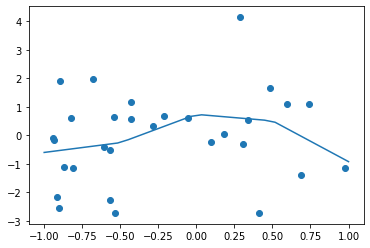

In [470]:
plt.plot(test_x, linear_model.predict(test_x.reshape(-1,1)))
plt.scatter(x,y)
plt.show()

## Use existing functions to implement a quadratic spline 2 knots. Choose your own knots.

In [471]:
from scipy.interpolate import interp1d

In [493]:
def quadratic_spline(x, y):
    return interp1d(x, y, kind='quadratic', fill_value="extrapolate")

In [494]:
quadratic_model = quadratic_spline(x,y)

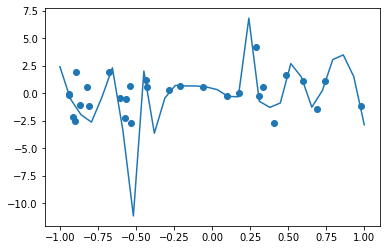

In [495]:
plt.plot(test_x, quadratic_model(test_x.reshape(-1,1)))
plt.scatter(x,y)
plt.show()

## Use existing functions to implement a natural cubic spline with 3 knots. Choose your own knots.

In [451]:
def my_cubic_reg(knots):
    return Pipeline([
        ('cubic', NaturalCubicSpline(knots=knots)),
        ('regression', LinearRegression())
    ])

In [475]:
cubic_model = my_cubic_reg(knots=[-0.5,0.5,1])

In [476]:
cubic_model.fit(x.reshape(-1,1), y)

Pipeline(memory=None,
         steps=[('cubic',
                 NaturalCubicSpline(knots=array([-0.5,  0.5,  1. ]), max=None,
                                    min=None, n_knots=3, n_params=2)),
                ('regression',
                 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
                                  normalize=False))],
         verbose=False)

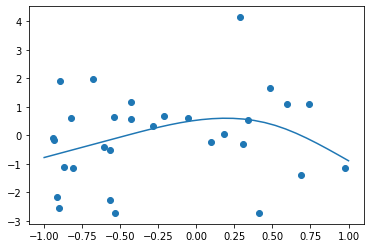

In [477]:
plt.plot(test_x, cubic_model.predict(test_x.reshape(-1,1)))
plt.scatter(x,y)
plt.show()

## Use existing functions to implement a smoothing spline. Use the built-in ordinary leave-one-out cross-validation to select the best tuning parameter.


In [478]:
def smooth_spline(x, y, **args):
    smooth_spline = robjects.r['smooth.spline']
    return smooth_spline(robjects.FloatVector(x), robjects.FloatVector(y), **args)

In [588]:
r_predict = robjects.r['predict']

In [586]:
results = smooth_spline(x, y, cv=True)

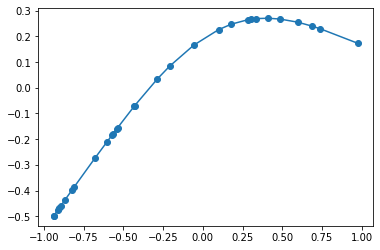

In [587]:
plt.plot(results[0], results[1], 'o-')
plt.show()

## After fitting these models, evaluate their performances by comparing the fitted functions with the true function value on an equispaced grid of 1000 points on [−1,1]. Use the squared distance as the metric. Repeat the entire process 200 times. Record and report the mean, median, and standard deviation of the errors for each method. Also, provide an informative boxplot that displays the error distribution for all models side-by-side.


In [508]:
def get_squared_distance(y_true, y_pred):
    return np.sum(np.square(y_true - y_pred))

In [596]:
linear_errors = []
quadratic_errors = []
cubic_errors = []
smooth_errors = []

x_test = np.linspace(-1, 1, num=1000)
y_test = np.sin(np.pi*x_test)
for i in range(1):
    x_train, y_train = gen_train_data()
    
    t_linear_model = make_pl_regression([-0.5,0,0.5]).fit(x_train.reshape(-1,1), y_train)
    t_quadratic_model = quadratic_spline(x_train,y_train)
    t_cubic_model = my_cubic_reg(knots=[-0.5,0.5,1]).fit(x_train.reshape(-1,1), y_train)
    t_smooth_model = smooth_spline(x_train, y_train, cv=True)
    
    y_linear_pred = t_linear_model.predict(x_test)
    y_quadratic_pred = t_quadratic_model(x_test)
    y_cubic_pred = t_cubic_model.predict(x_test)
    y_smooth_pred = r_predict(t_smooth_model, x_test)[1]
    
    linear_errors.append(get_squared_distance(y_test, y_linear_pred))
    quadratic_errors.append(get_squared_distance(y_test, y_quadratic_pred))
    cubic_errors.append(get_squared_distance(y_test, y_cubic_pred))
    smooth_errors.append(get_squared_distance(y_test, y_smooth_pred))

In [600]:
linear_errors_pd = pd.DataFrame(linear_errors)
quadratic_errors_pd = pd.DataFrame(quadratic_errors)
cubic_errors_pd = pd.DataFrame(cubic_errors)
smooth_errors_pd = pd.DataFrame(smooth_errors)

In [601]:
linear_errors_pd.describe()

,0
count,1.000000
mean,409.615684
std,NaN
min,409.615684
25%,409.615684
50%,409.615684
75%,409.615684
max,409.615684


In [602]:
quadratic_errors_pd.describe()

,0
count,1.000000
mean,208883.785105
std,NaN
min,208883.785105
25%,208883.785105
50%,208883.785105
75%,208883.785105
max,208883.785105


In [603]:
cubic_errors_pd.describe()

,0
count,1.000000
mean,605.093175
std,NaN
min,605.093175
25%,605.093175
50%,605.093175
75%,605.093175
max,605.093175


In [604]:
smooth_errors_pd.describe()

,0
count,1.000000
mean,639.471485
std,NaN
min,639.471485
25%,639.471485
50%,639.471485
75%,639.471485
max,639.471485


# Question 2 [50 Points] Multi-dimensional Kernel and Bandwidth Selection

In [434]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from mcmodels.regressors import NadarayaWatson
from sklearn import preprocessing
np.random.seed(i)

In [25]:
ccpp_data = pd.read_csv('CCPP.csv')

In [27]:
ccpp_data = ccpp_data.apply(pd.to_numeric, errors='coerce').dropna()

In [28]:
mm_scaler = preprocessing.MinMaxScaler()
ccpp_data = pd.DataFrame(mm_scaler.fit_transform(ccpp_data), columns=ccpp_data.columns)

In [29]:
ccpp_y = pd.DataFrame(ccpp_data.PE, columns=['PE']).to_numpy()

In [30]:
ccpp_x = ccpp_data.drop(['PE'], axis=1).to_numpy()

## Randomly select 2/3 of the data as training data, and rest as testing. Make sure you set a random seed. You do not need to repeat this process — just fix it and complete the rest of the questions

In [31]:
X_train, X_test, y_train, y_test = train_test_split(ccpp_x, ccpp_y, train_size=2/3, random_state=1)

In [32]:
print(f"{len(X_train)} in train and {len(X_test)} in test")
assert (len(X_train) + len(X_test)) == len(ccpp_data)

31893 in train and 15947 in test


## Fit the model on the training samples using the kernel estimator and predict on the testing sample. Calculate the prediction error and compare this to a linear model

In [33]:
def mean_square_error(y_true, y_pred):
    return np.square(np.subtract(y_true,y_pred)).mean()

#### Fit on kernel estimator

In [34]:
nw = NadarayaWatson()

In [35]:
nw.fit(X_train, y_train)

NadarayaWatson(coef0=1, degree=3, gamma=None, kernel='linear',
               kernel_params=None)

In [46]:
y_pred_nw = nw.predict(X_test)

In [47]:
nw_mse = mean_square_error(y_test, y_pred_nw)

In [48]:
print(f"Kernal estimator MSE {nw_mse}")

Kernal estimator MSE 0.04463322689384729


#### Fit on linear model

In [39]:
linear_reg = LinearRegression().fit(X_train, y_train)

In [40]:
y_pred_lm = linear_reg.predict(X_test)

In [41]:
lm_mse = mean_square_error(y_test, y_pred_lm)

In [42]:
print(f"Linear model estimator MSE {lm_mse}")

Linear model estimator MSE 0.0036381204562529815


## The bandwidth selection may not be optimal in practice. Experiment a few choices and see if you can achieve a better result.

In [50]:
from sklearn.model_selection import GridSearchCV

In [51]:
param_grid=dict(kernel=["rbf"], gamma=np.logspace(-2, 2, 25))
nw_gs = GridSearchCV(NadarayaWatson(), cv=5, param_grid=param_grid)

In [52]:
nw_gs = nw_gs.fit(X_train, y_train)

In [53]:
y_gs = nw_gs.predict(X_test)

In [54]:
gs_mse = mean_square_error(y_test, y_gs)

In [55]:
print(f"best bandwidth found: {nw_gs.best_estimator_.gamma} with MSE of: {gs_mse}")

best bandwidth found: 100.0 with MSE of: 0.003194717367384368


In [56]:
print(f"Linear Model MSE: {lm_mse}.\nBest bandwidth MSE: {gs_mse}")

Linear Model MSE: 0.0036381204562529815.
Best bandwidth MSE: 0.003194717367384368
